In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

### Loading the experiment scores

In [2]:

filename = 'results_hydroshoot_base_extra_envs.csv'
data = pd.read_csv(filename, index_col=0)

targets = data['target_id'].unique().tolist()
state_vars = data['reservoir_id'].unique().tolist()
datasets = data['dataset_id'].unique().tolist()

data = data.set_index(['target_id', 'reservoir_id', 'dataset_id'])
data = data.sort_values(['target_id', 'reservoir_id', 'dataset_id'], axis=0)

data.head(5)

test_score    train_mean  \
target_id reservoir_id dataset_id                                     
input_Rg  env_PAR      HydroShoot_large -2.482744e-15 -3.839161e-15   
          env_all      HydroShoot_large -6.235190e-15 -8.058575e-15   
          env_humidity HydroShoot_large -7.080059e-01 -5.976773e-01   
          env_temp     HydroShoot_large -6.207076e-01 -6.167873e-01   
          env_wind     HydroShoot_large -8.416829e-01 -7.950568e-01   

                                            train_std       cv_mean  \
target_id reservoir_id dataset_id                                     
input_Rg  env_PAR      HydroShoot_large  8.762430e-17 -3.865096e-15   
          env_all      HydroShoot_large  1.876845e-16 -8.369306e-15   
          env_humidity HydroShoot_large  1.958021e-02 -6.037453e-01   
          env_temp     HydroShoot_large  1.818662e-02 -6.289013e-01   
          env_wind     HydroShoot_large  1.083431e-02 -8.036872e-01   

                                               cv_std  
target_id reservoir_id dataset_id                      
input_Rg  env_PAR      HydroShoot_large  7.420274e-17  
          env_all      HydroShoot_large  1.806771e-15  
          env_humidity HydroShoot_large  8.390858e-02  
          env_temp     HydroShoot_large  7.526847e-02  
          env_wind     HydroShoot_large  4.421079e-02

### Visualizations

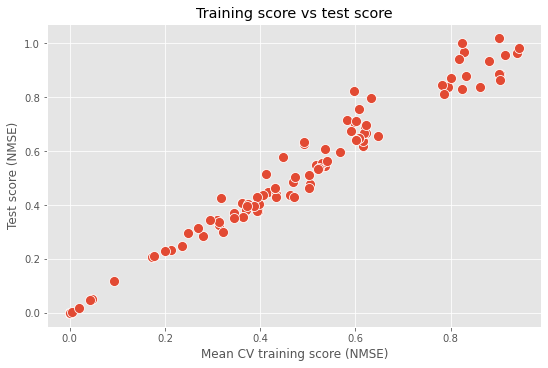

In [3]:
with plt.style.context('ggplot'):
  plot_data = data.loc[:, :, :, :].reset_index()
  plot_data['test_score'] *= -1
  plot_data['train_mean'] *= -1
  fig, ax = plt.subplots(1, 1, figsize=(1.5 * 5, 5), constrained_layout=True)
  sns.scatterplot(x='train_mean', y='test_score', s=100, data=plot_data, ax=ax)
  ax.set_title('Training score vs test score')
  ax.set_xlabel('Mean CV training score (NMSE)')
  ax.set_ylabel('Test score (NMSE)')

  # label outliers
  outlier_data = plot_data[plot_data['test_score'] > 2]

  def print_annotation(row):
    ax.text(row['train_mean'], row['test_score'], row['target_id'], rotation=0)

  outlier_data.apply(print_annotation, axis=1)

  plt.show()

In [7]:
from collections import defaultdict

color_map = defaultdict(lambda: '#D62728')
color_map['env_temp'] = '#2CA02C'
color_map['env_humidity'] = '#2CA02C'
color_map['env_PAR'] = '#2CA02C'
color_map['env_wind'] = '#2CA02C'
color_map['env_all'] = '#2CA02C'
color_map['state__het_all'] = '#1F77B4'

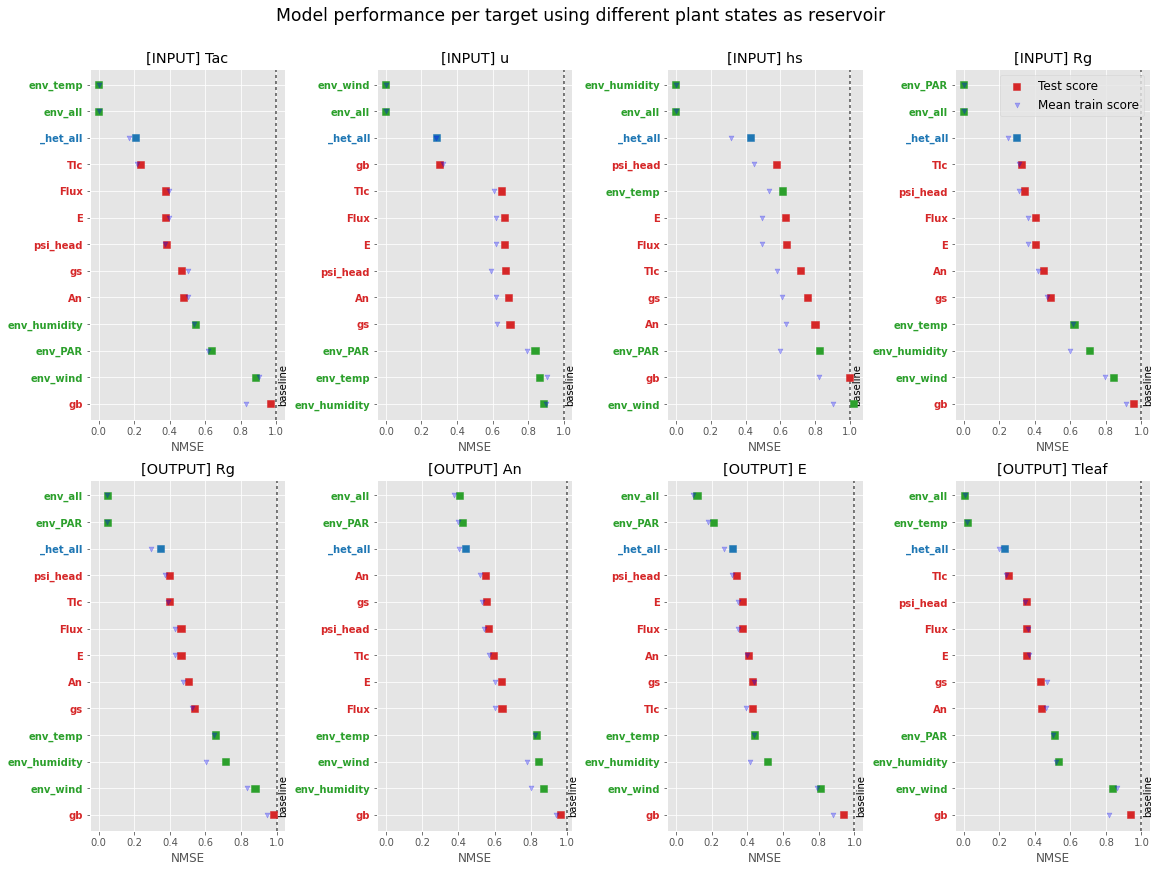

In [9]:
from scipy import stats

from model_config_hydroshoot import 

DO_NOT_PLOT = []

with plt.style.context('ggplot'):
  n_cols = 4
  n_rows = np.ceil(len(targets) / n_cols).astype(int)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 12), squeeze=False, sharey=False, constrained_layout=True)


  for target, ax in zip(targets, axs.flatten()):
    plot_data = data.loc[target, :, :].reset_index()
    plot_data = plot_data.sort_values(by='test_score', ascending=True)
    plot_data = plot_data.loc[~plot_data.index.isin(DO_NOT_PLOT)]


    # filter out outliers test scores with z score > 3
    plot_data = plot_data[(np.abs(stats.zscore(plot_data['test_score'])) < 3)]


    _state_vars = plot_data['reservoir_id'].unique()
    x = np.arange(len(_state_vars) - len(DO_NOT_PLOT))
    colors = [color_map[label] for label in plot_data['reservoir_id']]


    ax.axvline(1, dashes=(2, 2), color='black', alpha=0.66)
    ax.text(1.01, 0, 'baseline', fontsize='medium', rotation='vertical')
  
    ax.scatter(-plot_data['test_score'], x, label='Test score', color=colors, alpha=1, marker='s', s=50, zorder=10)
    ax.scatter(-plot_data['train_mean'], x, label='Mean train score', color='blue', alpha=0.3, marker='v', s=25, zorder=10)
    
    yticklabels = [label if label.startswith('env') else label[6:] for label in plot_data['reservoir_id']]
    ax.set_yticks(np.arange(len(_state_vars) - len(DO_NOT_PLOT)))
    ax.set_yticklabels(yticklabels, fontdict={'fontweight': 'demi'})
    ax.set_title(f'{target.replace("_", " ").replace("  ", " ").replace("input", "[INPUT]").replace("output", "[OUTPUT]")}')
    ax.set_xlabel('NMSE')
    ax.set_xlim(left=-0.05)
    if ax is axs[0][n_cols-1]:
      ax.legend(loc='upper right', fontsize='large')

    for ticklabel, tickcolor in zip(ax.get_yticklabels(), colors):
      ticklabel.set_color(tickcolor)

  for ax in axs.flatten()[len(targets):]:
    ax.remove()

  fig.suptitle(f'Model performance per target using different plant states as reservoir\n', size='xx-large')
  plt.show()

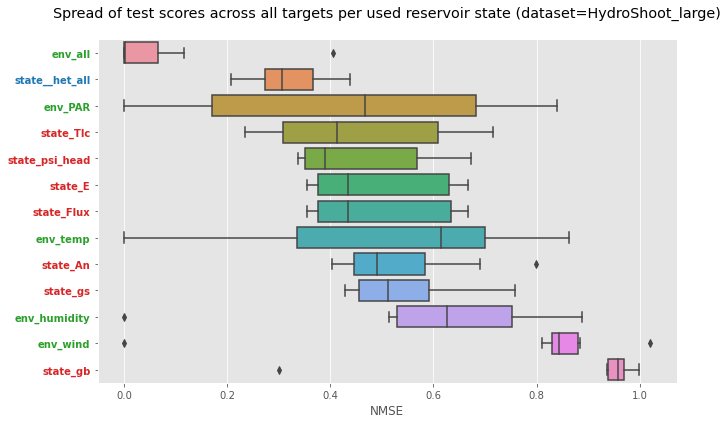

In [11]:
DO_NOT_PLOT = []

with plt.style.context('ggplot'):


  order = data.groupby('reservoir_id').mean().sort_values(by='test_score', ascending=False).index
  plot_data = data.loc[:, order, :].reset_index()
  plot_data = plot_data[~plot_data['reservoir_id'].isin(DO_NOT_PLOT)]
  plot_data['test_score'] *= -1


  # filter out outliers test scores with z score > 3
  plot_data = plot_data[(np.abs(stats.zscore(plot_data['test_score'])) < 3)]

  
  g = (sns
    .catplot(y='reservoir_id', x='test_score', kind='box', orient='h', data=plot_data, height=6, aspect=1.6)
    .set(title=f'Spread of test scores across all targets per used reservoir state (dataset={datasets[0]})\n', )
    .set(ylabel='', xlabel='NMSE'))

  for ticklabel in g.ax.get_yticklabels():
      ticklabel.set_color(color_map[ticklabel.get_text()])
      ticklabel.set_weight('demi')
      
  plt.tight_layout()
  plt.show()